In [16]:
import re
import numpy as np
import pandas as pd
import h5py

from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.core.calib import CalibBase
from mce.util.plot_base import PlotBase

In [2]:
myplt = PlotBase(palette='ipcc_wg1')

In [3]:
# Results from MIROC experiments
outpath = 'untracked/calib_miroc.h5'
ds = ScenarioBase(outpath=outpath, mode='r')

[2025-04-08 09:21:29 mce.core] INFO:untracked/calib_miroc.h5 already exists
[2025-04-08 09:21:29 mce.core] INFO:file untracked/calib_miroc.h5 opened with mode=r


## Driver for different BGC modes

In [4]:
class Driver(DriverBase):
    def preproc_add(self, **kw):
        self.bgc_mode = kw.get('bgc_mode', 'none')

    def emis_co2_in(self, t):
        emis = {'AFOLU': 0., 'FFI': 0.}
        ecum = {'AFOLU': 0.}
        return emis, ecum

    def erf_in(self, t, y):
        coc = y[self.map_y['ocean']]
        model = self.ocean

        if self.bgc_mode == 'land_only':
            catm = coc[0]

        else:
            nl = len(self.climate.parms.tauj)
            takj = y[self.map_y['climate']].reshape((nl, nl))
            tas = takj[0, :].sum()

            hls = model.parms.hlk[0]
            catm = model.partit(coc[0], hls, tas)

        cco2 = catm * model.parms.alphaa + model.parms.cco2_pi

        return self.forcing.c2erf(cco2)

    def func(self, t, y):
        ydot = super().func(t, y)

        emis_co2, ecum_co2 = self.emis_co2_in(t)

        cocdot = ydot[self.map_y['ocean']]
        cbsdot = ydot[self.map_y['land']]

        if self.bgc_mode == 'land_only':
            nl = len(self.climate.parms.tauj)
            takj = y[self.map_y['climate']].reshape((nl, nl))
            tas = takj[0, :].sum()

            model = self.ocean
            coc = np.array(y[self.map_y['ocean']])
            catm = coc[0]
            coc[0] -= catm
            cocdot[:] = -np.dot(model.msyst, coc)
            cocdot[0] += emis_co2.get('FFI', 0.)

            model = self.land
            save = self.save['land']
            cbs = y[self.map_y['land']]

            fert = model.fertmm(catm)

            # Assumption 1
            # Decrease in primary production is proportional
            # to cumulative AFOLU emissions
            cbs_pi0 = save['cbs_pi0'].sum()
            fert *= (
                model.parms.eff_afolu
                * (cbs_pi0 - ecum_co2.get('AFOLU', 0.)) / cbs_pi0
            )

            tau_l = model.get_tau(tas)
            cbsdot[:] = -cbs/tau_l + fert * model.parms.amp * tau_l

            # Assumption 2
            # AFOLU emissions affect wood component
            cbsdot[2] -= emis_co2.get('AFOLU', 0.)

            cocdot[0] -= cbsdot.sum()

        elif self.bgc_mode == 'ocean_only':
            cocdot[0] += cbsdot.sum()
            cbsdot[:] = 0.

        return ydot

    def postproc(self, **out):
        data = super().postproc(**out)

        cbs_pi = self.save['land']['cbs_pi']
        cbs = out['land'] - cbs_pi[:, None]
        data['cbst|plant'] = cbs[:3].sum(axis=0)
        data['cbst|soil'] = cbs[3]

        if self.bgc_mode == 'land_only':
            model = self.ocean
            coc = out['ocean']
            catm = coc[0, :]
            cco2 = catm * model.parms.alphaa + model.parms.cco2_pi
            coct = coc.sum(axis=0) - catm
            data['catm'] = catm
            data['cco2'] = cco2
            data['coct'] = coct

        df = pd.DataFrame(data).set_index('time').rename_axis(None)
        df['ctot'] = df[['catm', 'coct', 'cbst']].sum(axis=1)
        
        return df

## Base parameters

In [5]:
# Retrieve base concentration from the trend of esm-piControl
exp1 = 'esm-piControl'
grp = ds.file[f'calib/ES2L_CMIP6/{exp1}/detrend_cmip6']
df = (
    pd.DataFrame({k: v for k, v in grp.items()})
    .set_index('time').iloc[:100]
)
grp = ds.file[f'calib/ES2L_CMIP6/{exp1}/raw']
df_raw = (
    pd.DataFrame({k: v for k, v in grp.items()})
    .set_index('time').iloc[:100]
)
df_trend_cmip6 = df_raw - df

In [6]:
drv = DriverBase()
year_base = 1860
p = drv.ocean.parms
cco2_pi = df_trend_cmip6.loc[year_base, 'catm'] * p.alphaa
drv.ocean.update_pi(cco2_pi)
p.cco2_pi

284.1270998530492

In [7]:
kw_all = {
    'kw_ocean': {
        k: v for k, v in drv.ocean.parms().items()
        if k in ['cco2_pi', 'hlk', 'etak']
    },
    'kw_land': {
        k: v for k, v in drv.land.parms().items()
        if k in ['amp', 'tau', 'beta', 'fb_alpha', 'tsa_ref2']
    },
}
hlk, etak = drv.ocean._calib()
kw_all['kw_ocean'].update(hlk=hlk, etak=etak)
kw_all

{'kw_ocean': {'cco2_pi': 284.1270998530492,
  'hlk': array([  72.68985211,  482.97267125,  902.99498383, 1158.17716884]),
  'etak': array([20.26055344,  7.99350181,  4.04573425])},
 'kw_land': {'beta': 0.43,
  'fb_alpha': 0.87,
  'tsa_ref2': 3.5,
  'tau': array([  2.18181818,   2.85714286,  20.        , 100.        ]),
  'amp': array([-0.7184595 ,  0.702114  ,  0.01341303,  0.00293247])}}

In [8]:
parmdata = 'untracked/parms_calib.h5'
calib_set = [
    'climate/norm1__nl3',
    # 'ocean/BGC_step-4',
    # 'land/BGC_step-4',
]
parms = {}

with h5py.File(parmdata, mode='r') as h5f:
    for calib in calib_set:
        grp = h5f[f'CMIP6/MIROC-ES2L/{calib}']
        parms[calib] = {k: v for k, v in grp.attrs.items()}

In [9]:
p1 = parms['climate/norm1__nl3']
kw_all['kw_irm'] = {
    'asj': np.array([p1[f'a{j}'] for j in range(3)]),
    'tauj': np.array([p1[f'tau{j}'] for j in range(3)]),
    'lamb': p1['lambda'],
}
kw_all['kw_rfall'] = {
    'alpha': p1['co2_alpha'],
    'beta': p1['co2_beta'],
    'ccref': cco2_pi,
}

In [10]:
kw_all

{'kw_ocean': {'cco2_pi': 284.1270998530492,
  'hlk': array([  72.68985211,  482.97267125,  902.99498383, 1158.17716884]),
  'etak': array([20.26055344,  7.99350181,  4.04573425])},
 'kw_land': {'beta': 0.43,
  'fb_alpha': 0.87,
  'tsa_ref2': 3.5,
  'tau': array([  2.18181818,   2.85714286,  20.        , 100.        ]),
  'amp': array([-0.7184595 ,  0.702114  ,  0.01341303,  0.00293247])},
 'kw_irm': {'asj': array([0.30797088, 0.38143276, 0.31059636]),
  'tauj': array([  0.97030754,   9.81658392, 574.12900292]),
  'lamb': 1.439129059448229},
 'kw_rfall': {'alpha': 5.075389130967869,
  'beta': 1.1151588899039064,
  'ccref': 284.1270998530492}}

## Calibration

In [23]:
class CalibMiroc(CalibBase):
    # def __init__(self, ds_esm, **kw_all):
    def __init__(self, *Drivers, **kw_all):
        super().__init__(*Drivers, **kw_all)

        self.value_min_default = 0.5
        self.value_max_default = 1.5

        # self.Driver = Driver
        self.year_base = 1860
        self.pulse_size = []
        self.bgc_mode = 'none'

        # self.ds_esm = ds_esm
        self.map_exp = {
            (500, 'none'): 'pi-CO2pulse.e03',
            (500, 'both'): 'pi-CO2pulse.e04',
            (500, 'ocean_only'): 'pi-CO2pulse.e05',
            (500, 'land_only'): 'pi-CO2pulse.e06',
            (1000, 'none'): 'pi-CO2pulse.1000gtc.prc.e01',
            (1000, 'both'): 'pi-CO2pulse.1000gtc.prd.e01',
            (1000, 'ocean_only'): 'pi-CO2pulse.1000gtc.pro.e01',
            (1000, 'land_only'): 'pi-CO2pulse.1000gtc.prl.e01',
        }

    def set_experiment(self, pulse_size, bgc_mode):
        self.pulse_size = pulse_size
        self.bgc_mode = bgc_mode
        self.kw_ref['kw_ocean']['fbon'] = bgc_mode == 'none'
        self.kw_ref['kw_land']['fbon'] = bgc_mode == 'none'

    def get_model_config(self):
        config = []

        for pulse in self.pulse_size:
            config.append({
                comp: {} for comp in ['climate', 'ocean', 'land']       
            })
            config[-1]['ocean']['is_cdrv'] = False # emission-driven mode
            config[-1]['ocean']['init'] = np.array([pulse, 0., 0., 0.])

        return config

    def get_run_args(self):
        year_base = self.year_base
        din = None
        time = np.hstack([
            year_base - 0.5,
            np.arange(year_base, year_base + 100),
        ])
        ret = [((din, time), {'bgc_mode': self.bgc_mode})]
        return ret * len(self.pulse_size)

    def retrieve_model_parms(self, kw_all, **parms):
        for kind, p in parms.items():
            kw = kw_all[kind.replace('fac_', 'kw_')]
            for k, v in p.items():
                matched = re.match('^(hlk|etak|amp|tau)(.*)$', k)
                if matched:
                    kb, ki = matched.group(1, 2)
                    kw[kb][int(ki)] *= v
                else:
                    kw[k] *= v

            if kind == 'fac_land':
                amp = kw['amp']
                tau = kw['tau']
                dif = amp.sum()
                wt_a0 = 0.5
                amp[0] -= wt_a0*dif
                amp[1:] *= 1. - (1.-wt_a0)*dif / amp[1:].sum()
                tau /= (amp * tau).sum()

    def get_esm(self, pulse):
        ds = self.data[0]
        kfmt = 'calib/ES2L/{}/detrend_cmip6'.format
        exp1 = self.map_exp[(pulse, self.bgc_mode)]
        return (
            pd.DataFrame({k: v for k, v in ds.file[kfmt(exp1)].items()})
            .set_index('time').iloc[:100]
        )

    def get_diff(self, results):
        xdiff = []

        for pulse, df in zip(self.pulse_size, results):
            df = df.iloc[1:].rename(int)
            df_esm = self.get_esm(pulse)

            if self.bgc_mode in ['land_only', 'both']:
                variables = ['cbst|plant', 'cbst|soil']

            elif self.bgc_mode in ['ocean_only']:
                variables = ['coct']

            elif self.bgc_mode in ['none']:
                variables = ['coct', 'cbst|plant', 'cbst|soil']

            else:
                raise ValueError('invalid bgc_mode')

            for vn in variables:
                xdiff.append((df[vn] - df_esm[vn]).values)

        return np.hstack(xdiff)

### Step 1. Land carbon uptake parameters

In [24]:
kw_all_0 = kw_all
calib = CalibMiroc(Driver, **kw_all_0)
calib.set_experiment([500], 'land_only')
kw_all_1 = calib.minimize_wrap(
    ds,
    fac_land={k: 1. for k in ['amp0', 'tau3', 'beta']},
)
calib.ret.params

name,value,standard error,relative error,initial value,min,max,vary
fac_land__amp0,1.50000000,0.00204786,(0.14%),1.0,0.50000000,1.50000000,True
fac_land__tau3,0.78125373,0.00800249,(1.02%),1.0,0.50000000,1.50000000,True
fac_land__beta,1.32059501,0.04404053,(3.33%),1.0,0.50000000,1.50000000,True


In [25]:
kw_all_1['kw_land']

{'beta': 0.567855853513542,
 'fb_alpha': 0.87,
 'tsa_ref2': 3.5,
 'tau': array([ 1.86509438,  2.44238549, 17.09669846, 66.7842969 ]),
 'amp': array([-0.89807437,  0.8776425 ,  0.01676628,  0.00366559]),
 'fbon': False}

In [26]:
config = calib.get_model_config()[0]
args, kw = calib.get_run_args()[0]

drv = Driver(**{**kw_all_1, **config})
df_calib = drv.run(*args, **kw)

drv = Driver(**{**kw_all_0, **config})
df_base = drv.run(*args, **kw)

df_esm = calib.get_esm(calib.pulse_size[0])

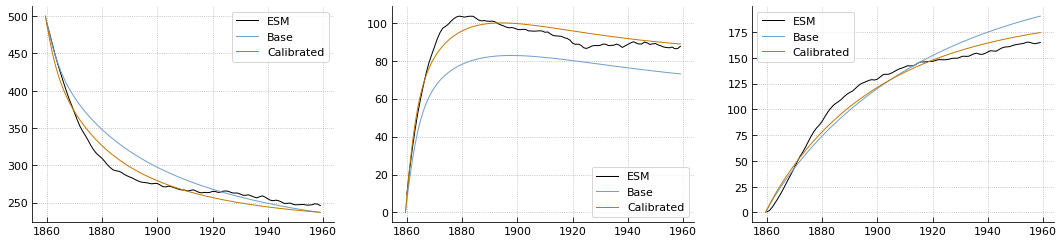

In [27]:
variable_order = ['catm', 'cbst|plant', 'cbst|soil']
myplt.init_regular(len(variable_order), col=3)
labels = ['ESM', 'Base', 'Calibrated']

for ax, vn in zip(myplt(), variable_order):
    for df, label in zip([df_esm, df_base, df_calib], labels):
        d1 = df[vn]
        ax.plot(d1.index, d1, label=label)

    ax.legend()
    ax.grid()

### Step 2. Ocean carbon uptake parameters

In [28]:
calib = CalibMiroc(Driver, **kw_all_1)
calib.set_experiment([500], 'ocean_only')
kw_all_2 = calib.minimize_wrap(
    ds,
    fac_ocean={k: 1. for k in ['hlk1', 'hlk2', 'etak0', 'etak1', 'etak2']},
)
calib.ret.params

name,value,standard error,relative error,initial value,min,max,vary
fac_ocean__hlk1,0.64518887,0.04560220,(7.07%),1.0,0.50000000,1.50000000,True
fac_ocean__hlk2,0.85993220,1.05875820,(123.12%),1.0,0.50000000,1.50000000,True
fac_ocean__etak0,1.24652658,0.03666150,(2.94%),1.0,0.50000000,1.50000000,True
fac_ocean__etak1,0.93140360,0.22459463,(24.11%),1.0,0.50000000,1.50000000,True
fac_ocean__etak2,1.50000000,0.17728994,(11.82%),1.0,0.50000000,1.50000000,True


In [ ]:
config = calib.get_model_config()[0]
args, kw = calib.get_run_args()[0]

drv = Driver(**{**kw_all_2, **config})
df_calib = drv.run(*args, **kw)

drv = Driver(**{**kw_all_1, **config})
df_base = drv.run(*args, **kw)

# df_esm = calib.get_esm(config['ocean']['init'][0])
df_esm = calib.get_esm(calib.pulse_size[0])

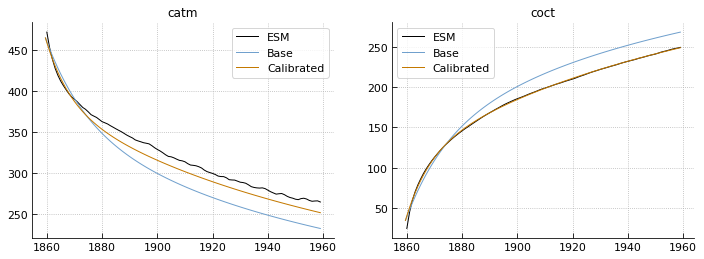

In [36]:
variable_order = ['catm', 'coct']
myplt.init_regular(len(variable_order), col=3)

for ax, vn in zip(myplt(), variable_order):
    for df, label in zip([df_esm, df_base, df_calib], labels):
        d1 = df[vn]
        ax.plot(d1.index, d1, label=label)

    ax.legend()
    ax.set_title(vn)
    ax.grid()

### Step 3. Land carbon uptake parameters (second)

In [37]:
calib = CalibMiroc(Driver, **kw_all_2)
calib.set_experiment([500], 'both')
kw_all_3 = calib.minimize_wrap(
    ds,
    fac_land={k: 1. for k in ['amp0', 'tau3', 'beta']},
)
calib.ret.params

name,value,standard error,relative error,initial value,min,max,vary
fac_land__amp0,1.50000000,0.03733122,(2.49%),1.0,0.50000000,1.50000000,True
fac_land__tau3,0.96623434,0.00713019,(0.74%),1.0,0.50000000,1.50000000,True
fac_land__beta,1.12738269,0.03309288,(2.94%),1.0,0.50000000,1.50000000,True


In [ ]:
config = calib.get_model_config()[0]
args, kw = calib.get_run_args()[0]

drv = Driver(**{**kw_all_3, **config})
df_calib = drv.run(*args, **kw)

drv = Driver(**{**kw_all_2, **config})
df_base = drv.run(*args, **kw)

df_esm = calib.get_esm(calib.pulse_size[0])

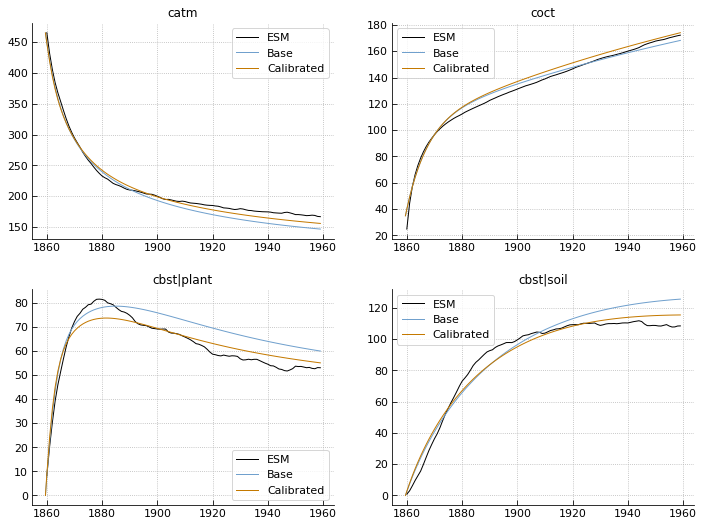

In [46]:
variable_order = ['catm', 'coct', 'cbst|plant', 'cbst|soil']
myplt.init_regular(len(variable_order), col=2)

for ax, vn in zip(myplt(), variable_order):
    for df, label in zip([df_esm, df_base, df_calib], labels):
        d1 = df[vn]
        ax.plot(d1.index, d1, label=label)

    ax.legend()
    ax.set_title(vn)
    ax.grid()

### Step 4. Land climate feedback parameters

In [47]:
calib = CalibMiroc(Driver, Driver, **kw_all_3)
calib.set_experiment([500, 1000], 'none')
kw_all_4 = calib.minimize_wrap(
    ds,
    fac_land={k: 1. for k in ['fb_alpha', 'tsa_ref2']},
)
calib.ret.params

name,value,standard error,relative error,initial value,min,max,vary
fac_land__fb_alpha,0.58197211,0.72514053,(124.60%),1.0,0.50000000,1.50000000,True
fac_land__tsa_ref2,1.50000000,1.29914740,(86.61%),1.0,0.50000000,1.50000000,True


In [51]:
df_calib = []
df_base = []
df_esm = []

for cfg, (args, kw), psize in zip(
    calib.get_model_config(),
    calib.get_run_args(),
    calib.pulse_size,
):
    drv = Driver(**{**kw_all_4, **cfg})
    df_calib.append(drv.run(*args, **kw))

    drv = Driver(**{**kw_all_3, **cfg})
    df_base.append(drv.run(*args, **kw))

    df_esm.append(calib.get_esm(psize))

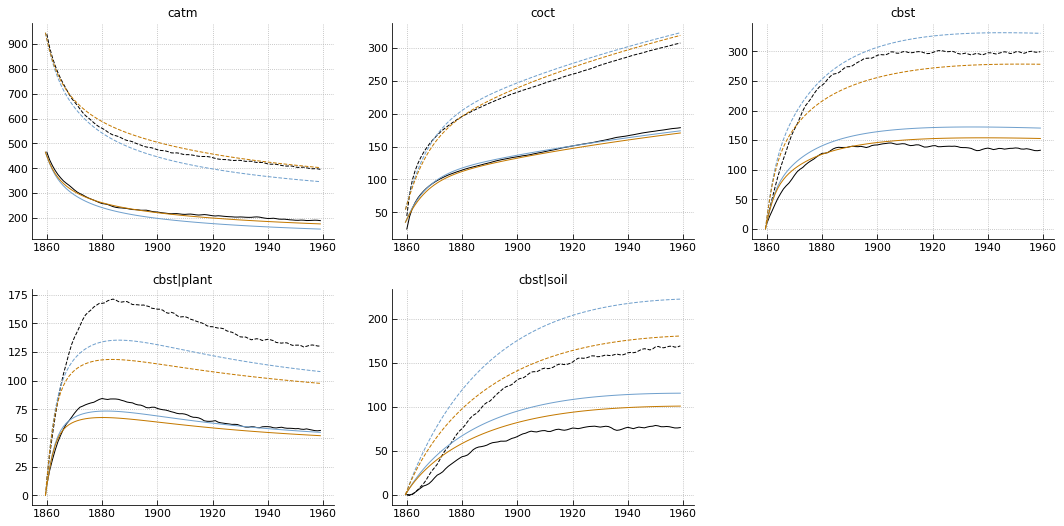

In [52]:
variable_order = ['catm', 'coct', 'cbst', 'cbst|plant', 'cbst|soil']
myplt.init_regular(len(variable_order), col=3)

lsx = ['-', '--']

for ax, vn in zip(myplt(), variable_order):
    for i, dfx in enumerate([df_esm, df_base, df_calib]):
        color = f'C{i}'
        for df, ls in zip(dfx, lsx):
            d1 = df[vn]
            ax.plot(d1.index, d1, color=color, ls=ls)

    ax.set_title(vn)
    ax.grid()

In [53]:
ds.close()

[2025-04-08 12:07:23 mce.core] INFO:file untracked/calib_miroc.h5 closed


In [54]:
kw_all_4

{'kw_ocean': {'cco2_pi': 284.1270998530492,
  'hlk': array([  72.68985211,  311.60858995,  776.51446255, 1158.17716884]),
  'etak': array([25.25531846,  7.4451764 ,  6.06860138]),
  'fbon': True},
 'kw_land': {'beta': 0.6401908604800999,
  'fb_alpha': 0.5063157388847892,
  'tsa_ref2': 5.2499999986763894,
  'tau': array([ 1.50451175,  1.97019396, 13.79135774, 52.05369934]),
  'amp': array([-1.12259297,  1.09705312,  0.02095785,  0.00458199]),
  'fbon': True},
 'kw_irm': {'asj': array([0.30797088, 0.38143276, 0.31059636]),
  'tauj': array([  0.97030754,   9.81658392, 574.12900292]),
  'lamb': 1.439129059448229},
 'kw_rfall': {'alpha': 5.075389130967869,
  'beta': 1.1151588899039064,
  'ccref': 284.1270998530492}}

In [56]:
with h5py.File(parmdata, mode='r') as h5f:
    grp = h5f['CMIP6/MIROC-ES2L/ocean/BGC_step-4__rev4a']
    kw_ocean = {k: v for k, v in grp.attrs.items()}
    grp = h5f['CMIP6/MIROC-ES2L/land/BGC_step-4__rev4a']
    kw_land = {k: v for k, v in grp.attrs.items()}

In [58]:
kw_all_4['kw_ocean']

{'cco2_pi': 284.1270998530492,
 'hlk': array([  72.68985211,  311.60858995,  776.51446255, 1158.17716884]),
 'etak': array([25.25531846,  7.4451764 ,  6.06860138]),
 'fbon': True}

In [57]:
kw_ocean

{'cco2_pi': 284.1270998530492,
 'etak': array([25.25531846,  7.4451764 ,  6.06860138]),
 'hlk': array([  72.68985211,  311.60858995,  776.51446255, 1158.17716884])}

In [59]:
kw_all_4['kw_land']

{'beta': 0.6401908604800999,
 'fb_alpha': 0.5063157388847892,
 'tsa_ref2': 5.2499999986763894,
 'tau': array([ 1.50451175,  1.97019396, 13.79135774, 52.05369934]),
 'amp': array([-1.12259297,  1.09705312,  0.02095785,  0.00458199]),
 'fbon': True}

In [60]:
kw_land

{'amp': array([-1.12259297,  1.09705312,  0.02095785,  0.00458199]),
 'beta': 0.6401908604800999,
 'fb_alpha': 0.5063157388847892,
 'tau': array([ 1.50451175,  1.97019396, 13.79135774, 52.05369934]),
 'tsa_ref2': 5.2499999986763894}

## Save calibration results

In [66]:
with h5py.File(parmdata, mode='a') as h5f:
    grp = h5f.create_group('CMIP6/MIROC-ES2L/ocean/BGC_step-4__rev4a')
    for k, v in calib.kw_ref[-1]['kw_ocean'].items():
        if k in ['fbon']:
            continue
        grp.attrs[k] = v

    grp = h5f.create_group('CMIP6/MIROC-ES2L/land/BGC_step-4__rev4a')
    for k, v in calib.kw_ref[-1]['kw_land'].items():
        if k in ['fbon']:
            continue
        grp.attrs[k] = v

In [68]:
with h5py.File(parmdata, mode='r') as h5f:
    for comp in ['ocean', 'land']:
        grp = h5f[f'CMIP6/MIROC-ES2L/{comp}/BGC_step-4__rev4a']
        print({k: v for k, v in grp.attrs.items()})

        grp = h5f[f'CMIP6/MIROC-ES2L/{comp}/BGC_step-4']
        print({k: v for k, v in grp.attrs.items()})

{'cco2_pi': 284.1270998530492, 'etak': array([25.25531846,  7.4451764 ,  6.06860138]), 'hlk': array([  72.68985211,  311.60858995,  776.51446255, 1158.17716884])}
{'cco2_pi': 283.52668262263654, 'eta1': 26.210136249420067, 'eta2': 8.730130905991674, 'eta3': 6.052034792965692, 'hl1': 289.84684548831046, 'hl2': 538.510161864538, 'hl3': 1155.015477949811, 'hls': 72.491417149409}
{'amp': array([-1.12259297,  1.09705312,  0.02095785,  0.00458199]), 'beta': 0.6401908604800999, 'fb_alpha': 0.5063157388847892, 'tau': array([ 1.50451175,  1.97019396, 13.79135774, 52.05369934]), 'tsa_ref2': 5.2499999986763894}
{'amp0': -1.1225929686523042, 'amp1': 1.0970531249045268, 'amp2': 0.02095785156067613, 'amp3': 0.004581992187101236, 'beta': 0.6442610255772605, 'fb_alpha': 0.49973319868528954, 'tau0': 1.5033202180712604, 'tau1': 1.9686336189028413, 'tau2': 13.78043533231989, 'tau3': 52.18531920832286, 'tsa_ref2': 5.249999998738599}
